In [1]:
import retinanalysis as ra
import retinanalysis.schema as schema
import numpy as np
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import pandas as pd

ra.djconnect()


[2025-07-03 15:50:10,581][INFO]: Connecting root@127.0.0.1:3306
[2025-07-03 15:50:10,622][INFO]: Connected root@127.0.0.1:3306


## Step 1: Query protocol across all experiments

In [2]:
protocols_to_query = ['movingletters', 'presentmatfiles']
experiment_query = ra.get_datasets_from_protocol_names(protocols_to_query)
display(experiment_query)


Found 1 protocols matching "movingletters":
['edu.washington.riekelab.protocols.MovingLetters']

Found 1 protocols matching "presentmatfiles":
['edu.washington.riekelab.protocols.PresentMatFiles']

Found 4 experiments, 6 epoch blocks.



,exp_name,datafile_name,NDF,chunk_name,protocol_name,is_mea,data_dir,group_label,experiment_id,protocol_id,group_id,block_id,chunk_id
0,20250514C,data003,0.5,movies_images,edu.washington.riekelab.protocols.PresentMatFiles,1,20250514C/data003,PresentMatFiles,132,68,2428,3485,563
1,20250514C,data015,0.5,moving_letters,edu.washington.riekelab.protocols.MovingLetters,1,20250514C/data015,DR Moving Letters,132,67,2440,3497,565
2,20250530C,data002,0.5,moving_letters,edu.washington.riekelab.protocols.MovingLetters,1,20250530C/data002,Moving Letters,139,67,2493,3560,595
3,20250429C,data007,0.5,moving_letters,edu.washington.riekelab.protocols.MovingLetters,1,20250429C/data007,DR moving letters,140,67,2501,3572,596
4,20250429C,data009,0.5,moving_letters,edu.washington.riekelab.protocols.MovingLetters,1,20250429C/data009,DR moving letters,140,67,2503,3574,596
5,20250527C,data010,0.5,moving_letters,edu.washington.riekelab.protocols.MovingLetters,1,20250527C/data010,Moving E,147,67,2661,3761,692


## Select experiment and data file of interest

In [3]:
exp_name = experiment_query.loc[0, 'exp_name']
datafile_name = experiment_query.loc[0,'datafile_name']

# Create stim, response, analysis_chunk and pipeline class
stim = ra.StimBlock(exp_name, datafile_name)
response = ra.ResponseBlock(exp_name, datafile_name)
analysis_chunk = ra.AnalysisChunk(exp_name, stim.nearest_noise_chunk)
pipeline = ra.MEAPipeline(stim, response, analysis_chunk)


Nearest noise chunk for data003 is chunk1 with distance 20 minutes.

Loading VCD from /Volumes/ExternalM2/mea_ssd/data/sorted/20250514C/data003/kilosort2.5 ...
Fetching EIs...


  0%|          | 0/884 [00:00<?, ?it/s]

VCD loaded with 884 cells.
Loading VCD from /Volumes/ExternalM2/mea_ssd/analysis/20250514C/chunk1/kilosort2.5 ...
Fetching params...


  0%|          | 0/781 [00:00<?, ?it/s]

Fetching EIs...


  0%|          | 0/781 [00:00<?, ?it/s]

VCD loaded with 781 cells.
Loaded spatial maps for channels [0, 2] and 781 cells of shape (88, 142, 2)
Analysis: True
Response: True
Stim: True

Ref clusters matched: 501
Ref clusters unmatched: 280
64.15% matched, 35.85% unmatched.


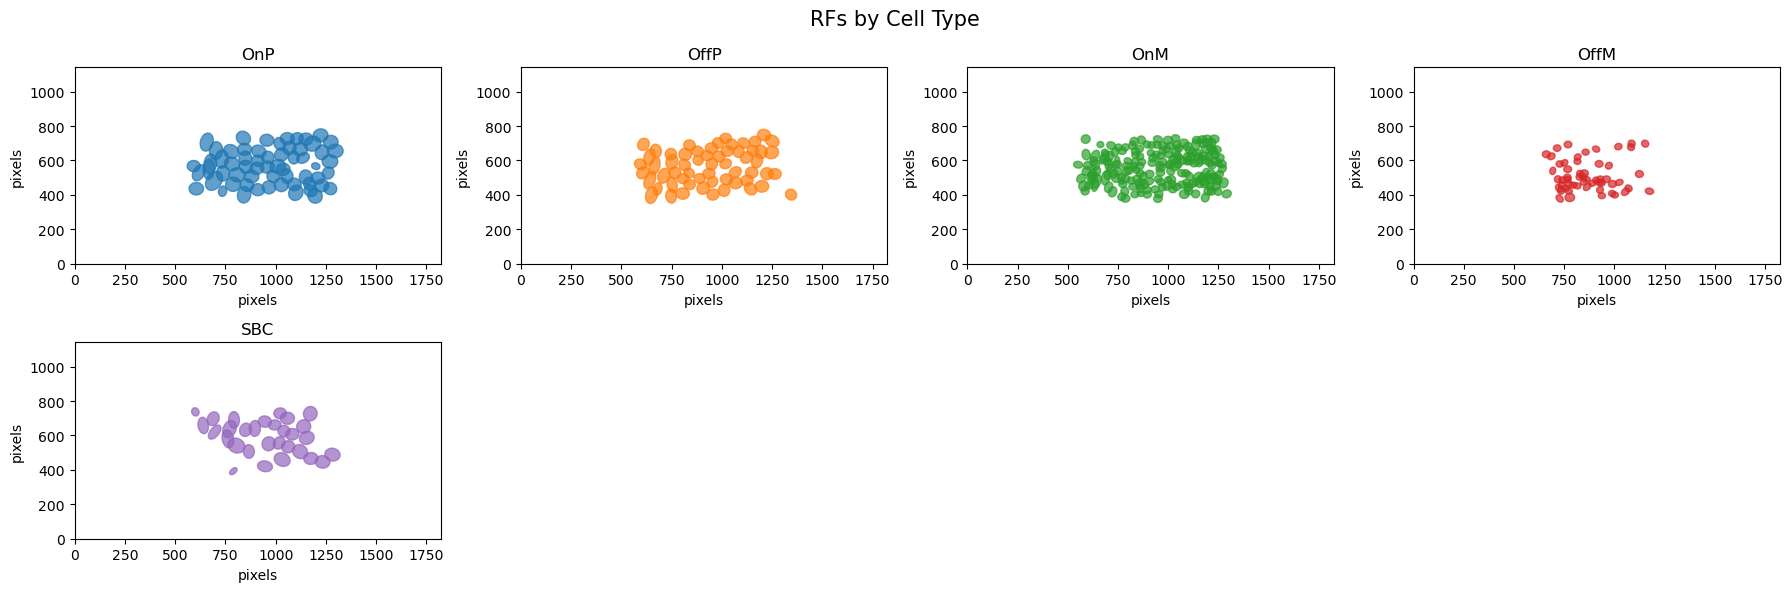

In [5]:
cell_types = ['OnP', 'OffP', 'OnM', 'OffM', 'SBC']
rf_axes = pipeline.plot_rfs(cell_types = cell_types, units = 'pixels');

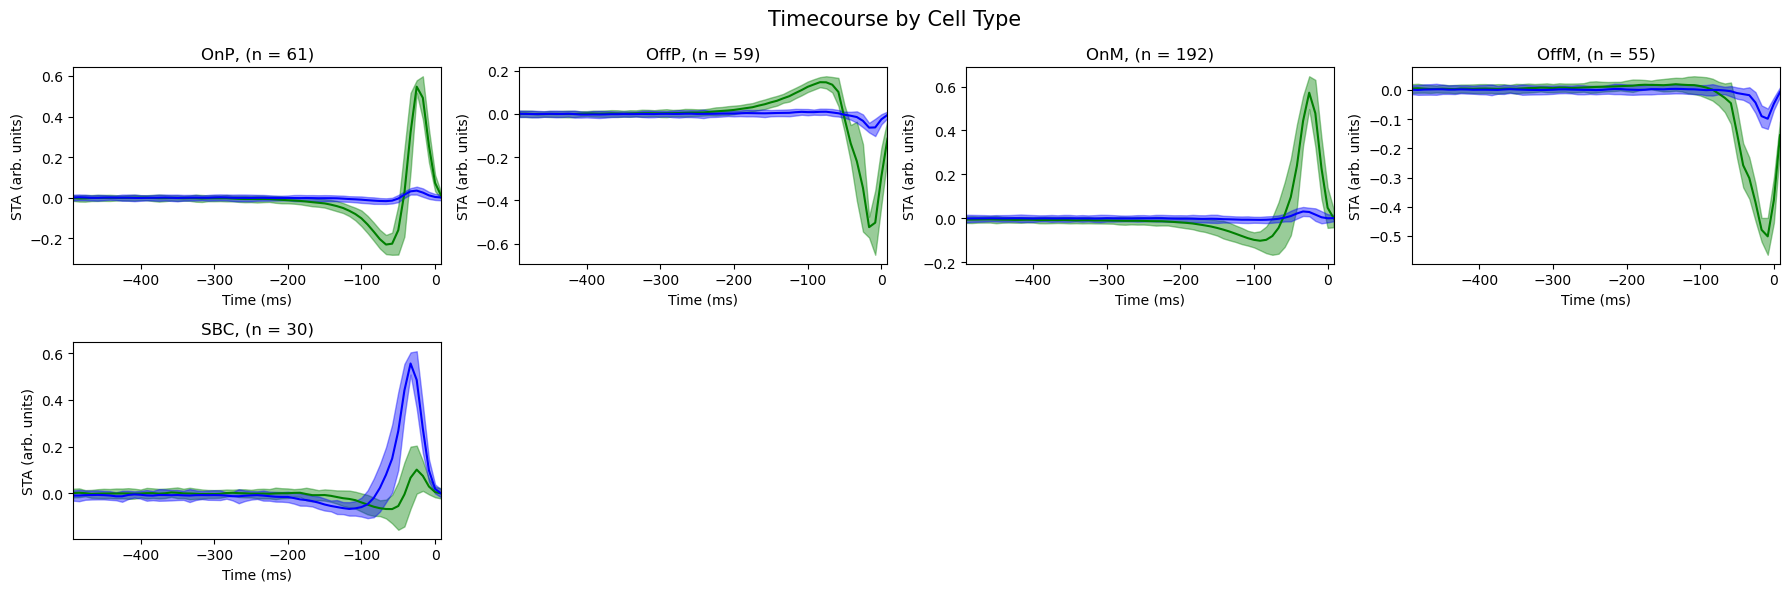

In [6]:
timecourse_axes = pipeline.plot_timecourses(cell_types = cell_types);

In [ ]:
epoch_params = ['imageOrder']
image_order = [lst for lst in stim.df_epochs['imageOrder']]
image_order = np.array(image_order)

# display(stim.df_epochs.columns)

images_per_epoch = stim.df_epochs.loc[0,'epoch_parameters']['imagesPerEpoch']
num_epochs = len(stim.df_epochs)

# epochs_to_see = [1, 2, 5, 245, 6, 232]
# display(stim.df_epochs[['imageOrder', 'matFile']].query('epoch_index == @epochs_to_see'))

cell_of_interest = 6
cell_1_times = response.df_spike_times.query('cell_id == 1')['spike_times'].values

OffP_noise_ids = analysis_chunk.df_cell_params.query('typing_file_0 == "OffP"')['cell_id'].values
OffP_protocol_ids = [pipeline.match_dict[cell] for cell in OffP_noise_ids if cell in pipeline.match_dict.keys()]
OffP_responses = response.df_spike_times.query('cell_id == @OffP_protocol_ids')
OffP_spike_times = OffP_responses['spike_times'].values

test = np.empty((OffP_spike_times.shape[0], OffP_spike_times[0].shape[0]), dtype = object)
for i in range(test.shape[0]):
    test[i,:] = OffP_spike_times[i]

print(test.shape)
fig, ax = plt.subplots()

epochs_to_plot = np.arange(0,9)
ax.eventplot(test[:,0], color = 'k', linewidths = 0.8, linelengths = 0.8)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Epoch")
